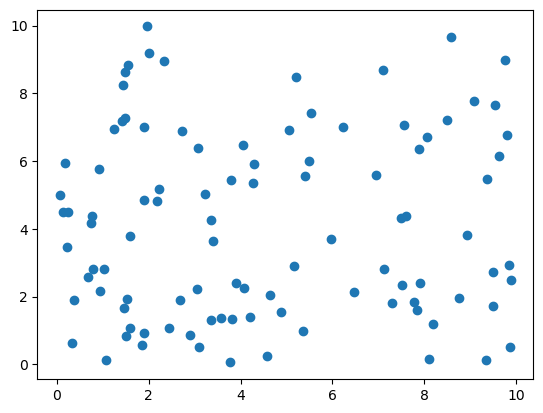

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Read the data from the file
data = np.loadtxt('mesh.dat', skiprows=1)
X = data[:, 0]
Y = data[:, 1]
plt.scatter(X,Y)  



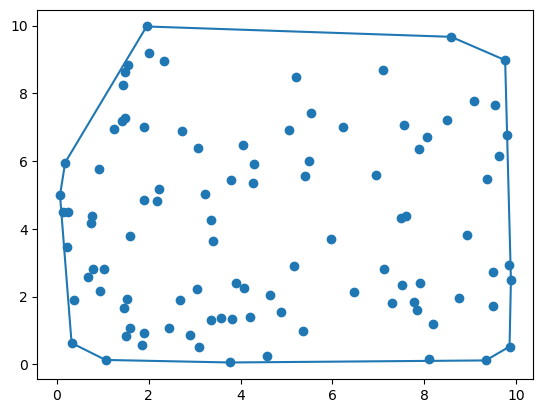

In [127]:
 #2D Graham scan 

def isCCW(v_a, v_b):
    crossprod = v_a[0]*v_b[1] - v_a[1]*v_b[0]
    return(crossprod>0)

def Grahamscan(data):
    Y = data[:, 1]
    ii = np.argmin(Y)        #find lowest y coordinate
    ipt = data[ii]
    length = len(data)
    angarr = np.zeros(length)
    for j in range(length):       #i'll take the dot product to represent an angle. a is the unit vector in x direction, b is displacement ot new pt
        a = [1,0]
        b = data[j]-ipt
        normb = np.sqrt(b[0]**2 + b[1]**2)
        if(j==ii):
            angarr[j] = -999
        else:
            angarr[j] = np.dot(a,b) / normb
    sort_indices = np.argsort(angarr)
    data_sorted = data[sort_indices]
    
    hull = []                           #data_sorted[0:3, :]   didn't do this since you can only append to lists
    for k in range(3):
        hull.append(data_sorted[k])    #adds first three points
        
    for i in range(3, length):
        cont=True
        while(cont):
            v_next = data_sorted[i]-hull[-1]
            v_prev = hull[-1]-hull[-2]
            if(isCCW(v_prev,v_next)):
                hull.pop()
                cont = True
            else:
                cont = False
                hull.append(data_sorted[i])
                
    
    hull.append(data_sorted[0]) #handles last step
    return hull
    

hull = np.array(Grahamscan(data))  #plots
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(X_f, Y_f)
plt.scatter(X,Y)    
    

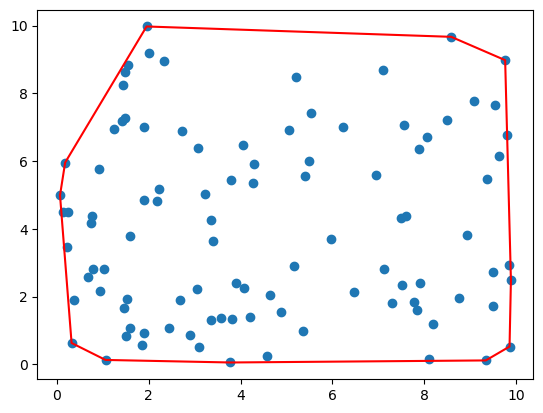

In [111]:
#Jarvis march


def orientation(p, q, r):     #returns 1 if CW, 2 if CCW
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])      #p is current point, q is next, r is next next
    if val == 0:
        return 0
    return 2 if val > 0 else 1

def jarvis_march(points):
    n = len(points)
    
    hull = []
    
    leftmost_idx = np.argmin(points[:, 0])
    p = leftmost_idx
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i
        
        p = q
        
        if p == leftmost_idx:  # Closed the loop
            break
    
    return np.array(hull)

# Compute the convex hull
hull = jarvis_march(data)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]), 'r-')  # Close the loop
plt.scatter(X, Y)
plt.show()

        

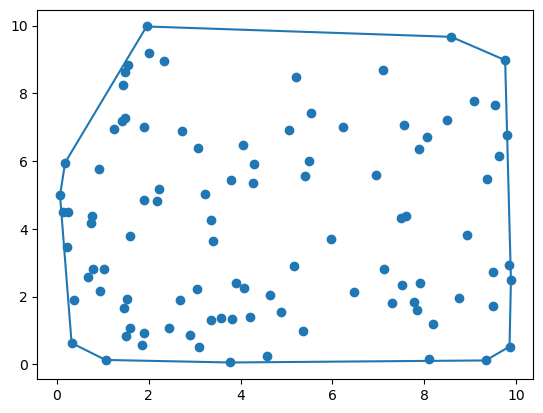

In [113]:
#quickhull


def triangle_area(p, q, r):
    return abs((q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - p[0])) / 2.0

def is_right_of_line(p, a, b):
    return (b[0] - a[0]) * (p[1] - a[1]) - (b[1] - a[1]) * (p[0] - a[0]) < 0

def quickhull_recursive(points, a, b, side):
    farthest_point = None
    max_area = 0
    
    # Find the point farthest from the line segment ab
    for p in points:
        if is_right_of_line(p, a, b) == side:
            area = triangle_area(a, b, p)
            if area > max_area:
                max_area = area
                farthest_point = p
    
    if farthest_point is None:  # Base case: no points on this side
        return [b]
    
    # Recursively find points on the farthest_point side of lines a-farthest_point and farthest_point-b
    left_of_ab = quickhull_recursive(points, a, farthest_point, side)
    right_of_ab = quickhull_recursive(points, farthest_point, b, side)
    
    return left_of_ab + [farthest_point] + right_of_ab

def quickhull(points):
    # Find the leftmost and rightmost points
    min_x_idx = np.argmin(points[:, 0])
    max_x_idx = np.argmax(points[:, 0])
    leftmost = points[min_x_idx]
    rightmost = points[max_x_idx]
    
    # Divide points into two subsets: above and below the line
    above = [p for p in points if is_right_of_line(p, leftmost, rightmost)]
    below = [p for p in points if is_right_of_line(p, rightmost, leftmost)]
    
    # Recursively find the convex hull points
    upper_hull = quickhull_recursive(above, leftmost, rightmost, True)
    lower_hull = quickhull_recursive(below, rightmost, leftmost, True)
    
    return [leftmost] + upper_hull + [rightmost] + lower_hull

# Compute the convex hull
hull = quickhull(data)

# Convert hull to a numpy array for easy plotting
hull = np.array(hull)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]))  # Close the loop
plt.scatter(X, Y)
plt.show()

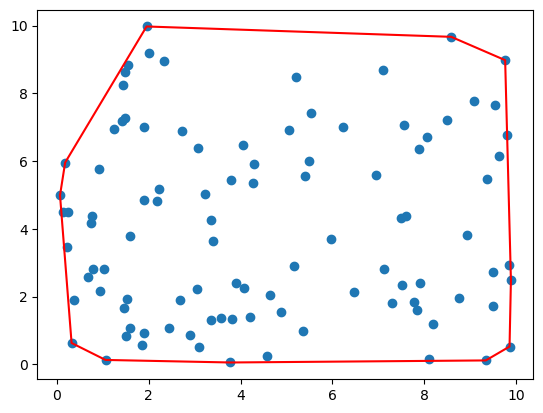

In [115]:
def monotone_chain(points):
    # Sort points
    points = sorted(points, key=lambda p: (p[0], p[1]))
    
    # Build the lower hull
    lower = []
    for p in points:
        while len(lower) >= 2 and orientation(lower[-2], lower[-1], p) != 2:  # Remove non-convex points
            lower.pop()
        lower.append(p)
    
    # Build the upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and orientation(upper[-2], upper[-1], p) != 2:  # Remove non-convex points
            upper.pop()
        upper.append(p)
    
    # Combine lower and upper hull, excluding the last point of each (it's repeated)
    return lower[:-1] + upper[:-1]

# Compute the convex hull
hull = monotone_chain(data)

# Convert hull to a numpy array for easy plotting
hull = np.array(hull)

# Plot the convex hull
X_f = hull[:, 0]
Y_f = hull[:, 1]
plt.plot(np.append(X_f, X_f[0]), np.append(Y_f, Y_f[0]), 'r-')  # Close the loop
plt.scatter(X, Y)
plt.show()


#note, I used Chatgpt to help me with the last 3 algorithms


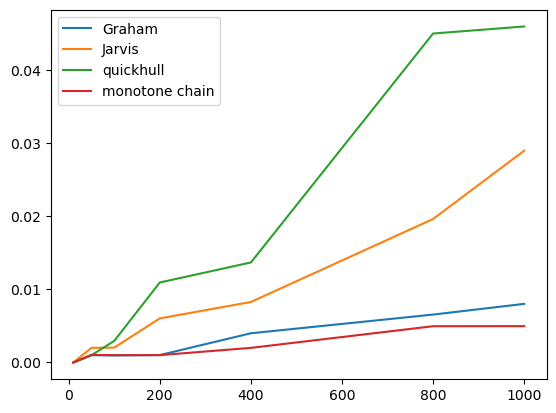

In [139]:
#now for time complexity
import time

def npointCloud(n):
    return np.random.rand(n,2)

G = []
J = []
Q = []
M = []

for n in [10,50,100,200,400,800,1000]:
    d = npointCloud(n)

    start_time = time.time()
    h_G = Grahamscan(d)
    end_time = time.time()
    G.append(end_time - start_time)

    start_time = time.time()
    h_J = jarvis_march(d)
    end_time = time.time()
    J.append(end_time - start_time)

    start_time = time.time()
    h_Q = quickhull(d)
    end_time = time.time()
    Q.append(end_time - start_time)

    start_time = time.time()
    h_M = monotone_chain(d)
    end_time = time.time()
    M.append(end_time - start_time)

plt.plot([10,50,100,200,400,800,1000], G, label= 'Graham')
plt.plot([10,50,100,200,400,800,1000], J, label= 'Jarvis')
plt.plot([10,50,100,200,400,800,1000], Q, label= 'quickhull')
plt.plot([10,50,100,200,400,800,1000], M, label= 'monotone chain')
plt.legend()
plt.show()
    


    

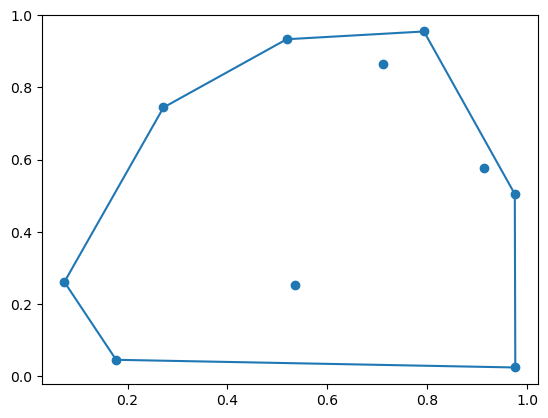

In [133]:
import random
random.seed(13)